In [1]:
!pip install git+https://github.com/nengo/nengo.git


  Cloning https://github.com/nengo/nengo.git to /tmp/pip-req-build-87u4bji6
  Running command git clone -q https://github.com/nengo/nengo.git /tmp/pip-req-build-87u4bji6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nengo: filename=nengo-3.1.0.dev0-cp36-none-any.whl size=423915 sha256=c83292943b580c5bd40b4a4d4544fe2872d58a16f043d3e452bda075e2eeba50
  Stored in directory: /tmp/pip-ephem-wheel-cache-7bz42uxm/wheels/dd/9f/dc/ef3a77bc5d15e40e5d146077fc401bc5315768f40ac8b044a7
Successfully built nengo


In [2]:
!pip install git+https://github.com/nengo/nengo-dl.git

  Cloning https://github.com/nengo/nengo-dl.git to /tmp/pip-req-build-_7v98zl4
  Running command git clone -q https://github.com/nengo/nengo-dl.git /tmp/pip-req-build-_7v98zl4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nengo-dl: filename=nengo_dl-3.2.1.dev0-cp36-none-any.whl size=196112 sha256=4e2484d1c6f0dbd1cb1c745561f7483215e0d9dc2ce36132000aa4e3ae3031b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qh2ndnp9/wheels/46/fd/04/bd7465e39155622b935d4d3c9703d853ee9cda1937629248e2
Successfully built nengo-dl
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [3]:
%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

In [4]:
#download mnist dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()

#flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))


11493376/11490434 [==============================] - 0s 0us/step


In [5]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None # this disables synaptic filtering

    # n_type = nengo.PoissonSpiking(nengo.RectifiedLinear())
    # n_type = nengo.RectifiedLinear()
    n_type = nengo.SpikingRectifiedLinear() 

    n_in = 784
    inter_dim = 128

    inp_node = nengo.Node(np.zeros(n_in))

    # first layer
    enc1 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(inp_node, enc1.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    enc2 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(enc1.neurons, enc2.neurons, transform=nengo_dl.dists.Glorot())

    # output layer
    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(enc2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    # probes
    p_c = nengo.Probe(outp.neurons)


    # from mnist example
    # out_p = nengo.Probe(outp, label="out_p")
    # out_p_filt = nengo.Probe(outp, synapse=0.1, label="out_p_filt")



In [6]:
minibatch_size = 50

with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
  sim.predict(np.ones((minibatch_size, 1, n_in)));

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:04                                               
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


## Training

A variety of training techniques are available. The current training technique mirrors traditional neural network training, mapping roughly to TensorFlow

In [7]:
# changing the model to more closely match how tensorflow works

for ens in auto_net.all_ensembles:
  ens.gain = nengo.dists.Choice([1]) # set all gains to 1
  ens.bias = nengo.dists.Choice([0]) # set all biases to 0 

# disables synaptic filtering.. eventually we want to use it though
for conn in auto_net.all_connections:
  conn.synapse = None 

In [8]:
# reshaping the data again for use in simulation, since with spiking networks simulations are temporal
# shape: (batch_size, n_steps, n)

train_data = train_data[:, None, :]

# # when testing our network with spiking neurons we will need to run it 
# # over time, so we repeat the input/target data for a number of 
# # timesteps.

n_steps = 100
test_data = np.tile(test_data[:, None, :], (1, n_steps, 1))


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

/usr/local/lib/python3.6/dist-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fb19244af98> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens
/usr/local/lib/python3.6/dist-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fb19243f128> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens
/usr/local/lib/python3.6/dist-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fb19243f2e8> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect.

Construction finished in 0:00:00                                               
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 95us/sample - loss: 1515.3485 - probe_loss: 1515.3473
Epoch 2/10
60000/60000 [==============================] - 6s 95us/sample - loss: 1051.0122 - probe_loss: 1051.0117
Epoch 3/10
60000/60000 [==============================] - 6s 95us/sample - loss: 948.1953 - probe_loss: 948.1952
Epoch 4/10
60000/60000 [==============================] - 6s 97us/sample - loss: 891.0670 - probe_loss: 891.0669
Epoch 5/10
60000/60000 [==============================] - 6s 95us/sample - loss: 862.5102 - probe_loss: 862.5096
Epoch 6/10
60000/60000 [==============================] - 6s 94us/sample - loss: 842.8598 - probe_loss: 842.8599
Epoch 7/10
60000/60000 [==============================] - 6s 94us/sample - loss: 827.5679 - probe_loss: 827.5679
Epoch 8/10
60000/60000 [==============================] - 6s 95us/sample - loss: 813.1786 - probe_loss

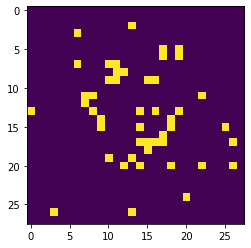

In [11]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
  sim.compile(optimizer = tf.optimizers.RMSprop(1e-3), 
  loss = tf.losses.mse) # mean squared error as loss function

  # run training loop. If using spiking neurons, this converts the model to a rate based approximation and then does training
  sim.fit(train_data, train_data, epochs = 10)

  # evaluate performance on test set
  print("Test error: ", sim.evaluate(test_data, test_data))

  # display example output
  output = sim.predict(test_data[:minibatch_size]) # runs sim.predict on the first minibatch of the data 
  plt.figure()
  # plt.imshow(output[p_c][0].reshape((28, 28)))
  plt.imshow(output[p_c][0, 99].reshape((28, 28)))